In [112]:
import torch
import numpy as np

from utils.utils import *
from utils.dataloader import *
from utils.nop import *

import matplotlib.pyplot as plt

In [113]:
# Data and model location
data_path = 'data/era5_Santos_2022-2023.nc'
bath_path = 'data/era5_Santos_2022-2023_bath.nc'

model_path = 'models/model_nm600_1250_ds300.0_r350.0_w20_kw40_d8_rl100.pt'

device = torch.device('cuda')

In [114]:
# Load model
model_data = torch.load(model_path, map_location=device)
pars = model_data['pars']

model = KernelNN(pars['model']['width'], pars['model']['kernel_width'], pars['model']['depth'], 3, in_width=3, out_width=1).to(device)
model.load_state_dict(model_data['model'])
model.eval()

KernelNN(
  (fc1): Linear(in_features=3, out_features=20, bias=True)
  (conv1): NNConv_old(20, 20)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)

In [115]:
# Case for evaluation
test_case = 1
#Second test case -> 90
n_vertices = 250
n_neighbors = 0
radius = pars['mesh']['radius']

In [116]:
# Load data and run model
d = data_loader(data_path,bath_path)
test_data = d.sample_graph(n_vertices, test_case, radius=radius, n_connections=0, validation=True, seed=0).to(device)

X = test_data.coords
F = test_data.x.cpu().detach().numpy()
G_t = test_data.y.cpu().detach().numpy()

with torch.no_grad():
    G_p = model(test_data).cpu().detach().numpy()[:,0]


lat = X[:,0]
lon = X[:,1]

wind_u = F[:,0]/d.wind_norm
wind_v = F[:,1]/d.wind_norm
bath = F[:,2]/d.bath_norm

shww_t = G_t/d.shww_norm
shww_p = G_p/d.shww_norm

D_sea = test_data.D_sea.cpu().detach().numpy()

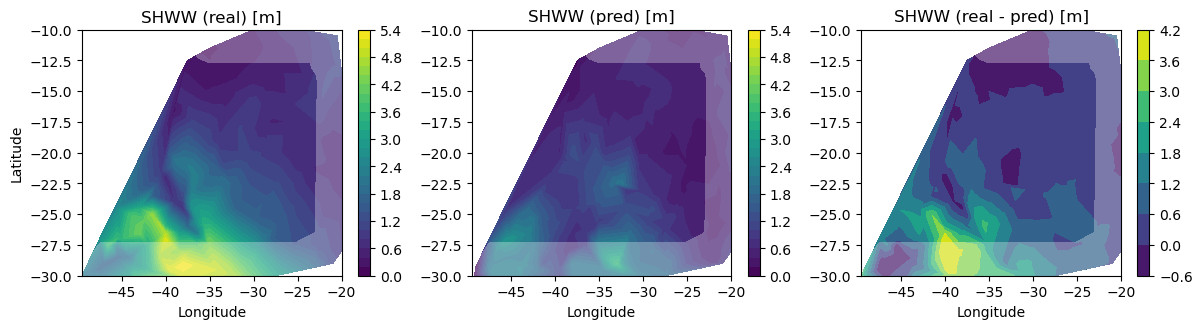

In [117]:
# Plot results
n_contours = 8
wind_step = 1
wave_step = 0.2

plt.figure(figsize=(12,3))

wind_max = wind_step*np.ceil(np.max((np.max(np.abs(wind_u)),np.max(np.abs(wind_v))))/wind_step)
wave_max = wave_step*np.ceil(np.max((np.max(np.abs(shww_t)),np.max(np.abs(shww_p))))/wave_step)

contours_wind = np.arange(-wind_max,wind_max+wind_step,wind_step)#wind_max*np.linspace(-1,1,n_contours)
contours_bath = np.linspace(0,1000,11)
contours_wave = np.arange(0,wave_max+wave_step,wave_step)#wave_max*np.linspace(0,1,n_contours)
contours_distance = [0, pars['train']['distance_to_sea']]

plt.subplot(1,3,1)
plt.tricontourf(lon,lat,shww_t,contours_wave)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('SHWW (real) [m]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(1,3,2)
plt.tricontourf(lon,lat,shww_p,contours_wave)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.xlabel('Longitude')
plt.title('SHWW (pred) [m]')

plt.subplot(1,3,3)
plt.tricontourf(lon,lat,shww_t-shww_p,n_contours)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.xlabel('Longitude')
plt.title('SHWW (real - pred) [m]')

plt.subplots_adjust(left=0.07, right=0.99, top=0.90, bottom=0.08)
#plt.savefig(f'prediction_c{test_case}_v{n_vertices}.pdf')

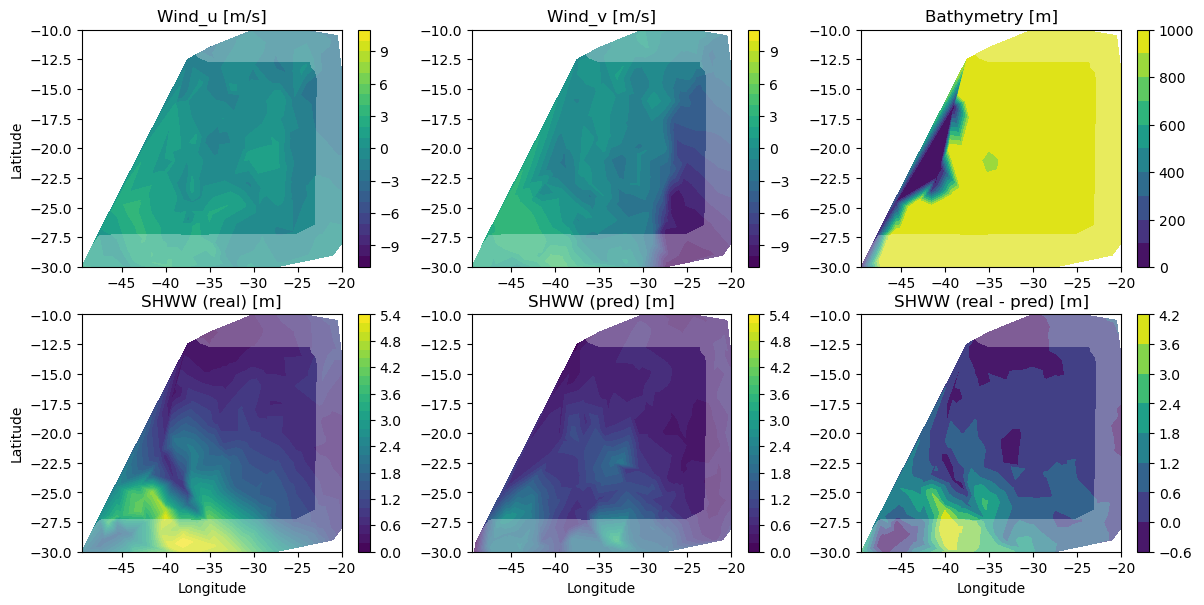

In [118]:
# Plot results
n_contours = 8
wind_step = 1
wave_step = 0.2

plt.figure(figsize=(12,6))

wind_max = wind_step*np.ceil(np.max((np.max(np.abs(wind_u)),np.max(np.abs(wind_v))))/wind_step)
wave_max = wave_step*np.ceil(np.max((np.max(np.abs(shww_t)),np.max(np.abs(shww_p))))/wave_step)

contours_wind = np.arange(-wind_max,wind_max+wind_step,wind_step)#wind_max*np.linspace(-1,1,n_contours)
contours_bath = np.linspace(0,1000,11)
contours_wave = np.arange(0,wave_max+wave_step,wave_step)#wave_max*np.linspace(0,1,n_contours)
contours_distance = [0, pars['train']['distance_to_sea']]

plt.subplot(2,3,1)
plt.tricontourf(lon,lat,wind_u,contours_wind)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('Wind_u [m/s]')
plt.ylabel('Latitude')

plt.subplot(2,3,2)
plt.tricontourf(lon,lat,wind_v,contours_wind)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('Wind_v [m/s]')

plt.subplot(2,3,3)
plt.tricontourf(lon,lat,bath,contours_bath)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('Bathymetry [m]')

plt.subplot(2,3,4)
plt.tricontourf(lon,lat,shww_t,contours_wave)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('SHWW (real) [m]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(2,3,5)
plt.tricontourf(lon,lat,shww_p,contours_wave)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.xlabel('Longitude')
plt.title('SHWW (pred) [m]')

plt.subplot(2,3,6)
plt.tricontourf(lon,lat,shww_t-shww_p,n_contours)
#plt.tricontourf(lon,lat,(shww_t-shww_p)/(shww_t+1e-10),np.linspace(-1,1,n_contours))
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.xlabel('Longitude')
plt.title('SHWW (real - pred) [m]')

plt.subplots_adjust(left=0.07, right=0.99, top=0.95, bottom=0.08)
plt.savefig(f'prediction_c{test_case}_v{n_vertices}.pdf')

In [119]:
def ioa(p,o):
    p = p.flatten()
    o = o.flatten()

    return 1 - (np.sum(np.square(o-p))/np.sum(np.square(np.abs(p-np.mean(o))+np.abs(o-np.mean(o)))))

In [120]:
vals_t = shww_t[D_sea>pars['train']['distance_to_sea']]
vals_p = shww_p[D_sea>pars['train']['distance_to_sea']]


print(np.max(vals_t)-np.max(vals_p))
print(np.mean(np.abs(vals_t-vals_p)))
print(ioa(vals_t,vals_p))

2.383218
0.6598275
0.6093476414680481


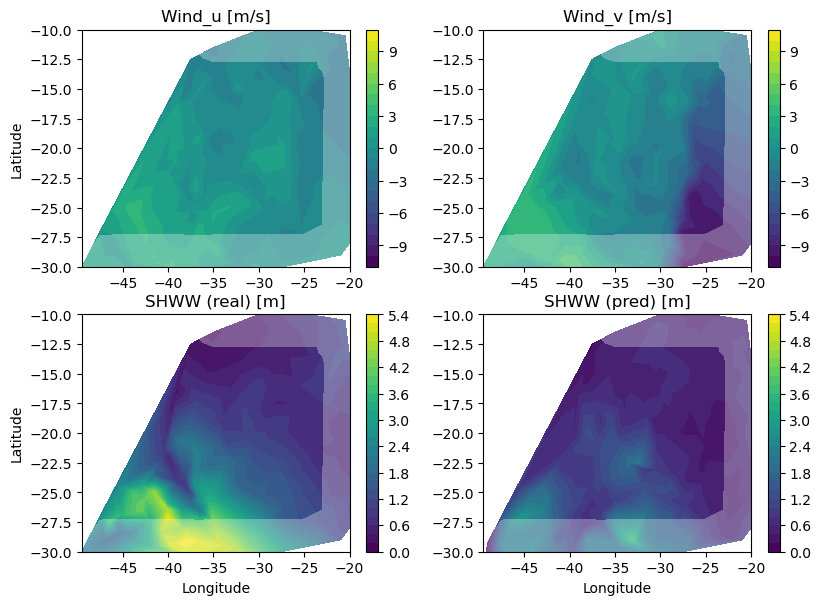

In [121]:
# Plot results
n_contours = 8
wind_step = 1
wave_step = 0.2

plt.figure(figsize=(8,6))

wind_max = wind_step*np.ceil(np.max((np.max(np.abs(wind_u)),np.max(np.abs(wind_v))))/wind_step)
wave_max = wave_step*np.ceil(np.max((np.max(np.abs(shww_t)),np.max(np.abs(shww_p))))/wave_step)

contours_wind = np.arange(-wind_max,wind_max+wind_step,wind_step)#wind_max*np.linspace(-1,1,n_contours)
contours_bath = np.linspace(0,1000,11)
contours_wave = np.arange(0,wave_max+wave_step,wave_step)#wave_max*np.linspace(0,1,n_contours)
contours_distance = [0, pars['train']['distance_to_sea']]

plt.subplot(2,2,1)
plt.tricontourf(lon,lat,wind_u,contours_wind)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('Wind_u [m/s]')
plt.ylabel('Latitude')

plt.subplot(2,2,2)
plt.tricontourf(lon,lat,wind_v,contours_wind)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('Wind_v [m/s]')

plt.subplot(2,2,3)
plt.tricontourf(lon,lat,shww_t,contours_wave)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('SHWW (real) [m]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(2,2,4)
plt.tricontourf(lon,lat,shww_p,contours_wave)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.xlabel('Longitude')
plt.title('SHWW (pred) [m]')

plt.subplots_adjust(left=0.07, right=0.99, top=0.95, bottom=0.08)
plt.savefig(f'prediction_c{test_case}_v{n_vertices}.pdf')

In [122]:
# Print metrics
def ioa(p,o):
    p = p.flatten()
    o = o.flatten()

    return 1 - (np.sum(np.square(o-p))/np.sum(np.square(np.abs(p-np.mean(o))+np.abs(o-np.mean(o)))))

print(f'MSE: {np.mean(np.square(d.shww_norm*(shww_p-shww_t)))}')
print(f'MAE: {np.mean(np.abs(d.shww_norm*(shww_p-shww_t)))}')
print(f'IOA: {ioa(shww_p,shww_t)}')

MSE: 3.7930185794830322
MAE: 1.2963804006576538
IOA: 0.6914262175559998


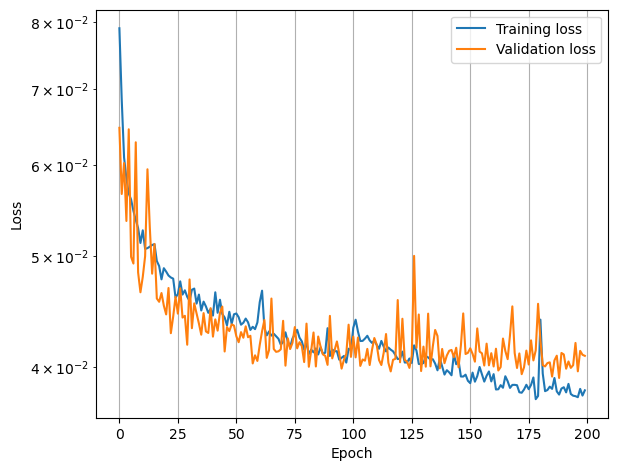

In [123]:
# Plot loss during training
plt.semilogy(model_data['loss'],label='Training loss')
plt.semilogy(model_data['loss_val'],label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)
plt.savefig('loss_history.pdf')

In [124]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

18881